In [123]:
from DatasetHandler.BiwiBrowser import *
from LSTM_VGG16.LSTM_VGG16Helper import *
%matplotlib inline

In [2]:
output_begin = 4
num_outputs = 1

In [197]:
timesteps = 56 # TimeseriesGenerator Handles overlapping
in_epochs = 1
out_epochs = 1
train_batch_size = 1
test_batch_size = 1

In [198]:
subjectList = [1] #, 2, 3, 4, 5, 7, 8, 11, 12, 14 except [6, 13, 10, ]
testSubjects = [1]

In [199]:
num_datasets = len(subjectList)

In [215]:
def getFinalModel(num_outputs = num_outputs):
    inp = (224, 224, 3) # BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = inp) #BIWI_Frame_Shape
    #vgg_model.layers.pop()
    
    #vgg_model.outputs = [vgg_model.layers[-1].output]
    #vgg_model.output_layers = [vgg_model.layers[-1]]
    #vgg_model.layers[-1].outbound_nodes = []
    nb_pretrained_layers = len(vgg_model.layers)
    
    for layer in vgg_model.layers: 
        layer.trainable = False
    #print(nb_pretrained_layers)
    #vgg_model.summary()
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2]), name = 'tdVGG16')) 
    rnn.add(TimeDistributed(Flatten()))
    
   # rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc1024'))
   # rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc104'))    
    rnn.add(TimeDistributed(Dense(1024, activation='relu'), name = 'fc10'))

    rnn.add(LSTM(1, dropout=0.25, recurrent_dropout=0.25))
    rnn.add(Dense(num_outputs))
    #print(len(rnn.layers))
    for layer in rnn.layers[:1]:
        layer.trainable = False
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [212]:
keras.backend.clear_session()#
full_model = getFinalModel(num_outputs = num_outputs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [213]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tdVGG16 (TimeDistributed)    (None, 56, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 56, 25088)         0         
_________________________________________________________________
fc10 (TimeDistributed)       (None, 56, 1024)          25691136  
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 4104      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 40,409,930
Trainable params: 25,695,242
Non-trainable params: 14,714,688
_________________________________________________________________


In [214]:
full_model = trainImageModelForEpochs(full_model, out_epochs, subjectList, testSubjects, timesteps, False, output_begin, num_outputs, batch_size = train_batch_size, in_epochs = in_epochs)

All frames and annotations from 1 datasets have been read by 2019-01-09 04:44:04.386441
1. set (Dataset 1) being trained for epoch 1!
Epoch 1/1
111/111 [==============================] - 110s 993ms/step - loss: 0.1791 - mean_absolute_error: 0.3611
Epoch 1 completed!


In [216]:
#[1]
test_generators, test_labelSets = getTestBiwiForImageModel(testSubjects, timesteps, False, output_begin, num_outputs, batch_size = test_batch_size)
test_gen, test_labels = test_generators[0], test_labelSets[0] 

All frames and annotations from 1 datasets have been read by 2019-01-09 04:46:17.306053


In [217]:
len(test_gen[0][0])

5

In [218]:
test_gen[23][0][0][0][124][110]

array([ 5.06099701,  9.22100067, 30.31999969])

In [222]:
predictions = full_model.predict_generator(test_gen, verbose = 1)
#predictions = full_model.predict(test_gen[0][0], verbose = 1)
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

ResourceExhaustedError: OOM when allocating tensor with shape[280,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: tdVGG16/block1_conv2/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](tdVGG16/block1_conv1/Relu, block1_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'tdVGG16/block1_conv2/convolution', defined at:
  File "/home/mcicek/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mcicek/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/mcicek/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/mcicek/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/mcicek/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-212-db225aecaf1f>", line 2, in <module>
    full_model = getFinalModel(num_outputs = num_outputs)
  File "<ipython-input-211-e30f2c23ea5d>", line 16, in getFinalModel
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2]), name = 'tdVGG16'))
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/models.py", line 497, in add
    layer(x)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 213, in call
    y = self.layer.call(inputs, **kwargs)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 782, in convolution
    return op(input, filter)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 870, in __call__
    return self.conv_op(inp, filter)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 522, in __call__
    return self.call(inp, filter)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 206, in __call__
    name=self.name)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 953, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/mcicek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[280,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: tdVGG16/block1_conv2/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](tdVGG16/block1_conv1/Relu, block1_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
 predictions

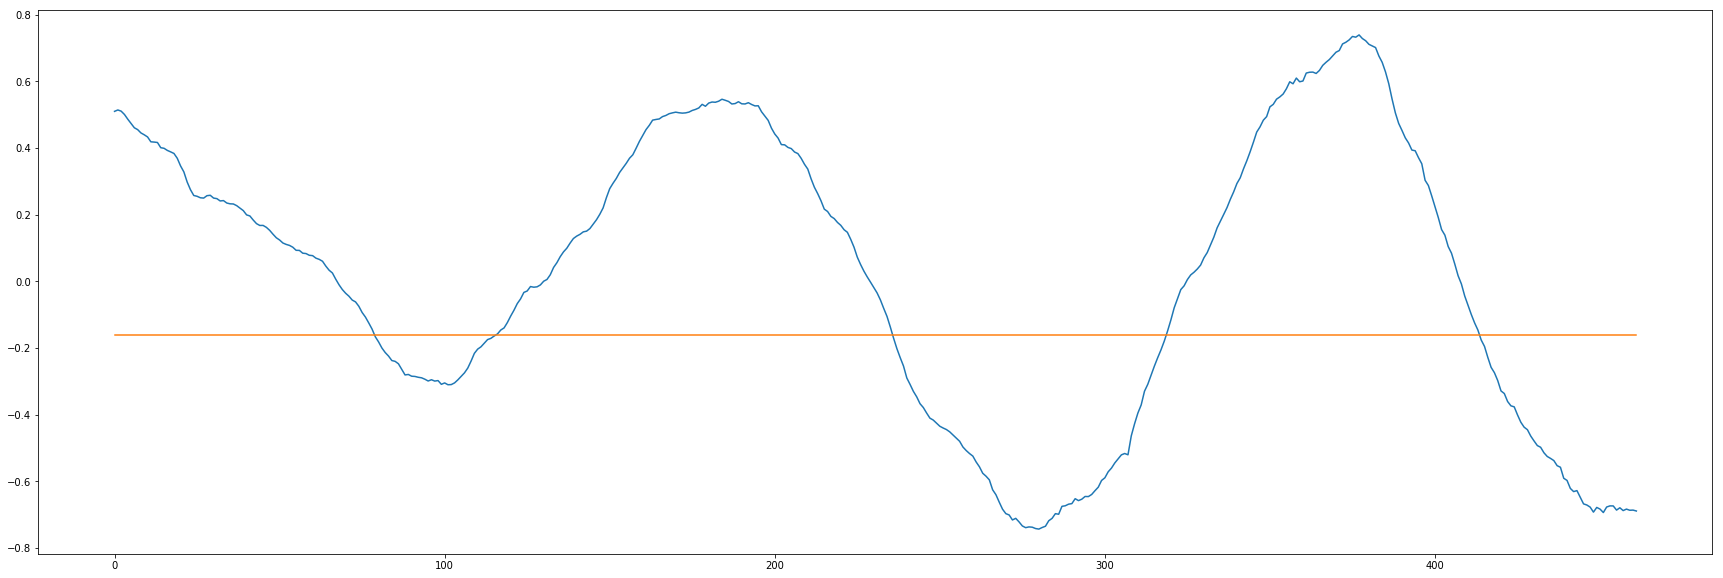

In [169]:
plt.figure(figsize=(30,10))
plt.plot(output1)